In [120]:
import numpy as np
from glob import glob
from skimage.io import imread
import matplotlib.pyplot as plt
from fish.image.vol import dff
import peakutils as pk
from skimage.exposure import adjust_gamma
from scipy.ndimage.filters import median_filter, gaussian_filter
import pims
import pandas as pd
from pathlib import Path
from os.path import sep,split
from collections import OrderedDict
import matplotlib
matplotlib.style.use('presentation')
%matplotlib inline

In [121]:
def tail_angle_wrapper(image, **kwargs):
    import fishtrack.measurements as meas
    return meas.tail_angle(np.array(image), **kwargs)

def get_events(data, thr_scale, duration):
    from fish.ephys.ephys import estimate_onset    
    thr = thr_scale * data.std() + np.median(data)
    events = estimate_onset(data, thr, duration=duration)
    
    return events

def affine_rect(center, width, height, angle, axis, **kwargs):
    import numpy as np
    from matplotlib.transforms import Affine2D
    from matplotlib.patches import Rectangle
    
    center_ = np.array(center)
    # center the rectangle on the supplied center point    
    rect_origin = center_ - np.array([width/2, height/2])
    
    rect = Rectangle(rect_origin, width, height, **kwargs)
    # define a translation moving the 
    trans = Affine2D().translate(*-center_)
    rot = Affine2D().rotate_deg(angle)
    tx = trans + rot + trans.inverted() + axis.transData
    rect.set_transform(tx)
    
    return rect

def axs_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
def make_composite_fish_image(raw, inset, scale, origin):
        from skimage.transform import resize
        inset = resize(inset, scale * np.array(inset.shape), preserve_range=True)
        raw[origin[0]:origin[0] + inset.shape[0], origin[1]:origin[1]+inset.shape[1]] = inset
    
        return raw, (*origin, *inset.shape)
    

In [122]:
exps = OrderedDict()

fs_im = 100
base_dir = '/groups/ahrens/ahrenslab/davis/data/epi/20170621/'

exp_dirs = list(Path(base_dir).iterdir())
exp_dirs.sort()

for expd in exp_dirs:
    exp_name = expd.parts[-1]
    raw_im_dir = expd / 'Pos0'
    mask_dir = expd / 'masks'
    if not mask_dir.exists():
        mask_dir = None
    aligned_fname = expd / (exp_name + '_aligned.tif')
    # we only work with experiments where the aligned images are saved
    if aligned_fname.exists():
        pos_params_fname = expd / (exp_name + '_position_data.npz')
        affine_params_fname = expd / 'regparams.npy'
        exps[exp_name] = {'raw_dir' : raw_im_dir, 
                          'aligned' : aligned_fname, 
                          'pos_params' : pos_params_fname, 
                          'affine_params_fname' : affine_params_fname,
                          'mask_dir' : mask_dir}
exp_names = list(exps.keys())
exps = pd.DataFrame(exps)

In [123]:
example_fish = '6dpf_cy221xcy221_f2_spon_1'
fish_ims_al = np.array(pims.open(str(exps[example_fish]['aligned'])))
fish_ims_raw = pims.ImageSequence(sorted(exps[example_fish]['raw_dir'].glob('*.tif')))
brain_pos = np.load(str(exps[example_fish]['pos_params']))['brain_centers']
affines = np.load(str(exps[example_fish]['affine_params_fname']))
fish_ind = 0

tail_angle = tail_angle_wrapper(fish_ims_al, center=(100,200), radius=110)

/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/pims/api.py:191: UserWarning: <class 'pims.tiff_stack.TiffStack_tifffile'> errored: 'NoneType' object has no attribute 'TiffFile'
  warn(message)


In [124]:
import pyqtgraph as pq
%gui qt
pq.image(fish_ims_al)

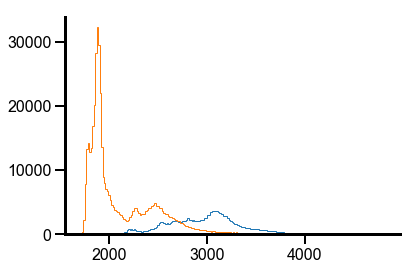

In [125]:
plt.hist(fish_ims_al[roi['brain']].ravel(), 200, histtype='step');
plt.hist(fish_ims_al[roi['sc']].ravel(), 200, histtype='step');

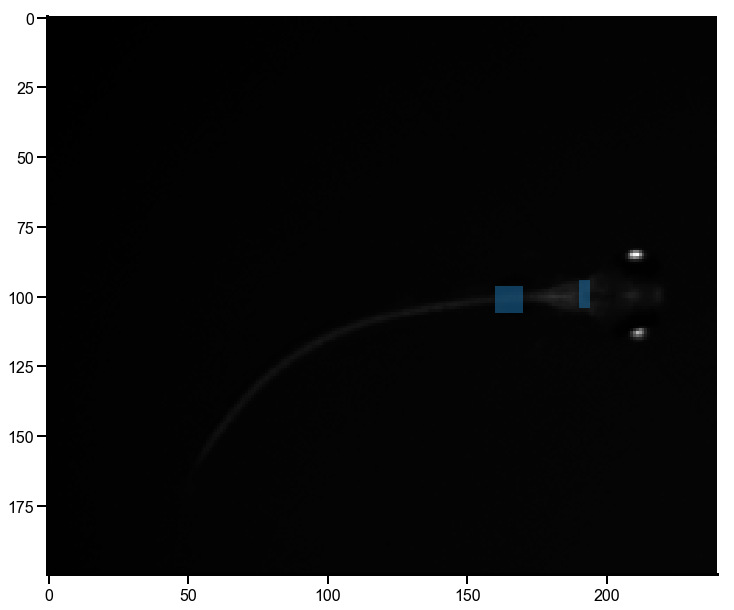

In [126]:
fig, axs = plt.subplots(figsize=(12,12))
axs.imshow(fish_ims_al[-100:].max(0),cmap='gray')
roi = {}
roi['brain'] = (slice(min(tpoints)- 2000, max(tpoints) + 2000), slice(94, 104), slice(190, 194))
roi['sc'] = (slice(min(tpoints)- 2000, max(tpoints) + 2000), slice(96, 106), slice(160, 170))
for k, r in roi.items():
    p = Rectangle((r[2].start, r[1].start), r[2].stop - r[2].start, r[1].stop - r[1].start, alpha=.5)
    axs.add_patch(p)

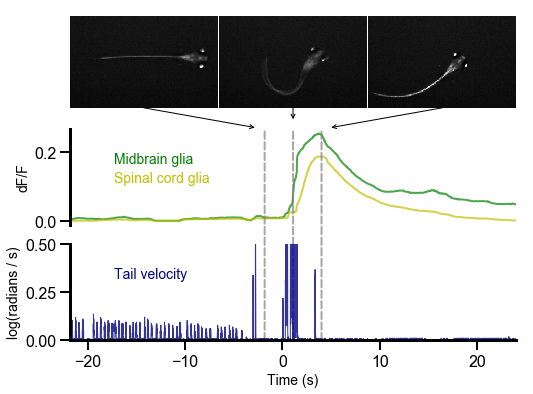

In [128]:
# Make sequence of images showing struggle and fluorescence
# use 6dpf_cy221xcy221_f2_spon_1_aligned.tif

from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch, Rectangle

tpoints = (13838, 14130, 14422)
colors = {'fl_ts_brain':'g','fl_ts_sc':'y', 'tail_ts':'navy'}
roi = {}
roi['brain'] = (slice(min(tpoints)- 2000, max(tpoints) + 2000), slice(94, 104), slice(190, 194))
roi['sc'] = (slice(min(tpoints)- 2000, max(tpoints) + 2000), slice(96, 106), slice(160, 170))

x_axis = (np.arange(roi['brain'][0].start, roi['brain'][0].stop)) / fs_im
struggle_time = 140.2
x_axis -= struggle_time

fig = plt.figure(figsize=(8,6))
gs = GridSpec(nrows=3, ncols=3, height_ratios=(1,1,1))
axs_ims = []

fontsize=14

# set the clim based on the brain fluorescence, not the eyes
# x position before eyes appear in image
eye_cutoff = 200
crop_c = 10
clim = min([fish_ims_al[t][crop_c:-crop_c, crop_c:-eye_cutoff].min() for t in tpoints]), max([fish_ims_al[t][crop_c:-crop_c, crop_c:eye_cutoff].max() for t in tpoints])
# show fish images
for ind, t in enumerate(tpoints):
    axs_ims.append(fig.add_subplot(gs[0,ind]))
    raw = fish_ims_raw[t].copy()
    inset = fish_ims_al[t].copy()[80:120,160:225]
    scale = 2
    ori = (10,10)
    #composite, bbox = make_composite_fish_image(raw[50:-50, 50:-50].T, inset, scale, ori)
    #inset_border = Rectangle(bbox[:2][::-1], bbox[3], bbox[2], fill=False, color='white', linewidth=1, alpha=.8)
    #axs_ims[-1].imshow(composite, cmap='gray', clim=clim, origin='lower')    
    #axs_ims[-1].add_patch(inset_border)
    axs_ims[-1].imshow(raw[100:-150, 220:-130].T, cmap='gray', clim=clim)
    axs_ims[-1].axis('off')

axs_ts = []
axs_ts.append(fig.add_subplot(gs[1,:]))
axs_ts.append(fig.add_subplot(gs[2,:]))

fl_ts = fish_ims_al[roi['brain']].mean((1,2))
fl_ts = dff(fl_ts, 100 * fs_im, 10, baseline_offset=10)

fl_ts = median_filter(fl_ts, 100).clip(min=0, max=None)

axs_ts[0].plot(x_axis, fl_ts, color=colors['fl_ts_brain'], linewidth=2, alpha=.7)

thr = 1500
fl_ts = fish_ims_al[roi['sc']]
fl_ts = np.array([f[f > thr].mean() for f in fl_ts])
fl_ts = dff(fl_ts, 100 * fs_im, 10, baseline_offset=10)

fl_ts = median_filter(fl_ts, 100).clip(min=0, max=None)

axs_ts[0].plot(x_axis, fl_ts, color=colors['fl_ts_sc'], linewidth=2, alpha=.7)

axs_ts[0].set_ylabel('dF/F', fontsize=fontsize)
#axs_ts[0].annotate('$\itgfap$:GCaMP6f fluorescence', (.1,.65), xycoords='axes fraction',color=colors['fl_ts_brain'], fontsize=18, fontname='Arial')
axs_ts[0].annotate('Midbrain glia', (.1,.65), xycoords='axes fraction',color=colors['fl_ts_brain'], fontsize=fontsize)
axs_ts[0].annotate('Spinal cord glia', (.1,.45), xycoords='axes fraction',color=colors['fl_ts_sc'], fontsize=fontsize)

tail_ts = np.log(1 + np.abs(np.diff(tail_angle[0][roi['brain'][0]])))
axs_ts[1].plot(x_axis[1:], tail_ts, alpha=.8, color=colors['tail_ts'], linewidth=1)
axs_ts[1].set_ylim(0,.5)
axs_ts[1].set_ylabel('log(radians / s)', fontsize=fontsize)
axs_ts[1].annotate('Tail velocity', (.1,.65), xycoords='axes fraction',color=colors['tail_ts'], fontsize=fontsize)

axs_ts[1].set_xlabel('Time (s)', fontsize=fontsize)
axs_format(axs_ts[1])
axs_format(axs_ts[0])
list(map(axs_format, axs_ts))
[ax.set_xlim(x_axis[0], x_axis[-1]) for ax in axs_ts]
axs_ts[0].spines['bottom'].set_visible(False)

# Draw dotted lines for the sampled timepoints
for ind, t in enumerate(tpoints):
    xyA = (x_axis[(t - roi['brain'][0].start)], axs_ts[1].get_ylim()[0])
    xyB = (x_axis[(t - roi['brain'][0].start)], axs_ts[0].get_ylim()[-1])
    coordsA = "data"
    coordsB = "data"
    con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA=coordsA, coordsB=coordsB,
                      axesA=axs_ts[1], axesB=axs_ts[0],shrinkB=0,color='grey', linestyle='--', alpha=.7, linewidth=2)
    axs_ts[1].add_artist(con)

# erase x-axis for top timeseries plot
axs_ts[0].tick_params(
    axis='x',
    which='both',
    bottom='off',
    top='off',
    labelbottom='off')

# Stick connecting lines between images and timeseries
for ind, t in enumerate(tpoints):
    xyA = (.5,0)
    xyB = (x_axis[(t - roi['brain'][0].start)], axs_ts[0].get_ylim()[-1])
    coordsA = "axes fraction"
    coordsB = "data"
    con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA=coordsA, coordsB=coordsB,
                      axesA=axs_ims[ind], axesB=axs_ts[0],
                      arrowstyle="->", shrinkB=10)

    axs_ims[ind].add_artist(con)

plt.subplots_adjust(wspace=.01)
plt.savefig('/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/{0}_struggle_example.pdf'.format(example_fish))